## Loading Data

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from logging import warning
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll
from helper_plot import hdr_plot_style
import torch
from utils import *
import logging
import warnings
import seaborn as sns
from tqdm import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib.font_manager').disabled = True
hdr_plot_style()

## This version uses the mnist dataset as an example because it is very lightweight, but any other image dataset can be used instead.

In [7]:
mnist_data = MNIST('/mnist_data', download=True, transform=transforms.ToTensor())

(-0.5, 27.5, 27.5, -0.5)

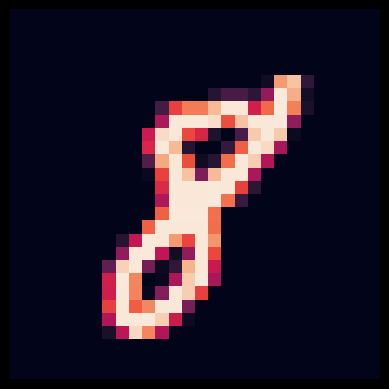

In [8]:
plt.imshow((mnist_data[17][0]).squeeze())
plt.axis('off')

In [9]:
class ImageData(torch.utils.data.Dataset):
    def __init__(self, mnist):
        self.data = mnist

    def __len__(self):
        return len(self.data)

    def get_shape(self):
        return self.data[0][0].squeeze().shape

    def __getitem__(self, idx):
        # return self.data[idx][0].flatten()
        return self.data[idx][0]

In [10]:
data_set = ImageData(mnist_data)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=32, shuffle=True)

In [11]:
num_steps = 1000
#betas = torch.tensor([1.7e-5] * num_steps)
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [12]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

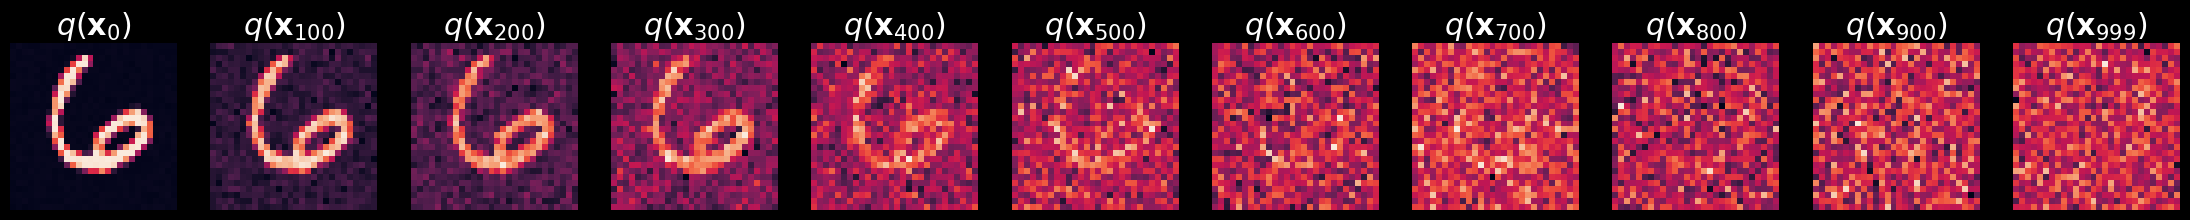

In [13]:
fig, axs = plt.subplots(1, 11, figsize=(28, 3))
sample_x = next(iter(data_loader))[0]
for i in range(11):
    q_i = q_x(sample_x, torch.tensor([min(i * num_steps//10, num_steps-1)]))
    # axs[i].imshow(q_i.reshape(data_set.get_shape()))
    axs[i].imshow(q_i[0])
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(min(i * num_steps//10, num_steps-1))+'})$')

In [14]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

In [15]:
def normalize(x, x_max=None, x_min=None):
    if x_max is not None and x_min is not None:
        normed_x = ((x - x_min) / (x_max - x_min)) * 2 -1
    else:
        normed_x = ((x - x.min()) / (x.max() - x.min())) * 2 -1
    return  normed_x

def denormalize(normed_x, x_max, x_min):
    x = ((normed_x + 1) / 2) * (x_max - x_min) + x_min
    return x

In [16]:
# data_max , data_min = dataset.max(), dataset.min()
# dataset = normalize(dataset)

In [17]:
from model import ConditionalModel
from unet_model import Unet
from ema import EMA
import torch.optim as optim

device = ('cuda' if torch.cuda.is_available() else 'cpu')
# model = ConditionalModel(len(data_set[0]), num_steps).to(device)
model = Unet(dim=64, channels=1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#dataset = torch.tensor(data.T).float()
# Create EMA model
model.to(device)
ema = EMA(0.9)
ema.register(model)
epochs = 10
for t in range(epochs):
    # X is a torch Variable
    data_iter = iter(data_loader)
    # for batch_x in data_iter:
    for i in tqdm(range(len(data_loader)), position=0, leave=True):
        batch_x = next(data_iter)
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if not (t % max((epochs//20), 1)):
        print(f'Current loss at step {t + (t + 1) * len(data_loader)} = {loss.item()}')
        with torch.no_grad():
          x_seq = p_sample_loop(model, data_set[0].unsqueeze(0).shape, num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(16, 4))
        for i in range(1, 11):
            cur_x = x_seq[min(i * 100, num_steps-1)].detach()
            # axs[i-1].imshow(cur_x.reshape(data_set.get_shape()))
            axs[i-1].imshow(cur_x[0][0])
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$p(\mathbf{x}_{'+str(num_steps - i*(num_steps//10))+'})$')
        plt.savefig('./mnist_train_progress/' + f'step={t + (t + 1) * len(data_loader)}.png')
        # plt.show()
        plt.close()

100%|██████████| 1875/1875 [05:06<00:00,  6.12it/s]


Current loss at step 1875 = 0.05067197605967522


 75%|███████▍  | 1398/1875 [03:48<01:14,  6.41it/s]

In [ ]:
# import gc
# gc.collect()
# model = None
# with torch.no_grad():
#     torch.cuda.empty_cache()
# gc.collect()

## Animation

In [18]:
# Generating the forward image sequence

import io
from PIL import Image

imgs = []
sample_x = next(iter(data_loader))[0]
#fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in tqdm(range(0, num_steps, 10)):
    plt.clf()
    q_i = q_x(sample_x, torch.tensor([i]))
    # plt.imshow(q_i.reshape(data_set.get_shape()))
    plt.imshow(q_i[0])
    plt.axis('off')
    plt.title('$q(\mathbf{x}_{'+str(i)+'})$', color='white',  y=1.08)

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)
    

In [19]:
# Generating the reverse diffusion sequence
reverse = []
# x_seq = p_sample_loop(model, data_set[0].unsqueeze(0).shape, num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
for i in tqdm(range(0, num_steps, 10)):
    plt.clf()
    cur_x = x_seq[i].detach()
    # plt.imshow(cur_x.reshape(data_set.get_shape()))
    plt.imshow(cur_x[0][0])
    plt.axis('off')
    plt.title('$p(\mathbf{x}_{'+str(num_steps - i)+'})$', color='white',  y=1.08)

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

In [20]:
imgs = imgs + reverse

In [21]:
imgs[0].save("diffusion_mnist.gif", format='GIF', append_images=imgs,save_all=True, duration=100, loop=0)

In [22]:
torch.save(model, 'mnist_unet.pt')